# Synaptic events, the NMC portal, and the NEURON GUI

____
Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Bruno Magalhaes @ Blue Brain Project

Werner Van Geit @ Blue Brain Project

____

A detailed simulation of large networks of neurons is computationally very costly, tipically requiring execution on supercomputers. Therefore, if one intends to study the synaptic connections on a single neuron, we can add the correct synaptic input and simulate its activity, instead of simulating the whole network.

In this tutorial we will explore such methods by:
- exploring the neuron models from the Blue Brain Project [NMC portal](https://bbp.epfl.ch/nmc-portal/welcome);
- exploring the synaptic events and current clamps via the NEURON graphical interface and python API;
- performing a simulation of a paired patch-clamp experiment;
____

# Exercise 1 - The NMC portal morphologies and NEURON GUI

### Before we start

1. Go to the [NMC portal](https://bbp.epfl.ch/nmc-portal/) , enter the the [MicroCircuit](https://bbp.epfl.ch/nmc-portal/microcircuit) section. Navigate the list of cells on the left column, pick a Layer 5 cell (L5_*) and click Download Model. If in doubt, download the  [L5_TTPC2_cADpyr](https://bbp.epfl.ch/nmc-portal/microcircuit#/metype/L5_TTPC2_cADpyr/details);
2. Extract the files in the folder from where you are executing this notebook.

### Mechanisms

In NEURON, any entity that affects the voltage of the neuron compartments, is called a *mechanism*. Some examples are current clamps, ion channels, gap junctions, random noise, extra-celullar space, etc. Mechanisms are described by the [NMODL](http://www.neuron.yale.edu/neuron/static/docs/help/neuron/nmodl/nmodl.html) language and stored as text files with the extension *.mod*. The main benefit of this approach is that any scientist can improve and test new models by simply creating new mechanisms, and without changing the source code of NEURON itself. This is the case for the [ModelDB](https://senselab.med.yale.edu/modeldb/) and [Channelpedia](http://channelpedia.epfl.ch/) databases.

The model you have just downloaded includes a folder called *mechanisms*. If you are curious about how mechanisms are written, look inside any mod file. Once you are done, run the following on a terminal window, in order to compile the mechanisms:

- nrnivmodl ./mechanisms/

If all went well, you will see the output 'Successfully created x86_64/special' on your terminal. The *special* binary file includes all your mechanisms compiled.

Once you've compiled your mechanisms, open the NEURON graphical interface by typing the following in a new terminal tab (from your "NMC_portal" folder):
- sh run_hoc.sh

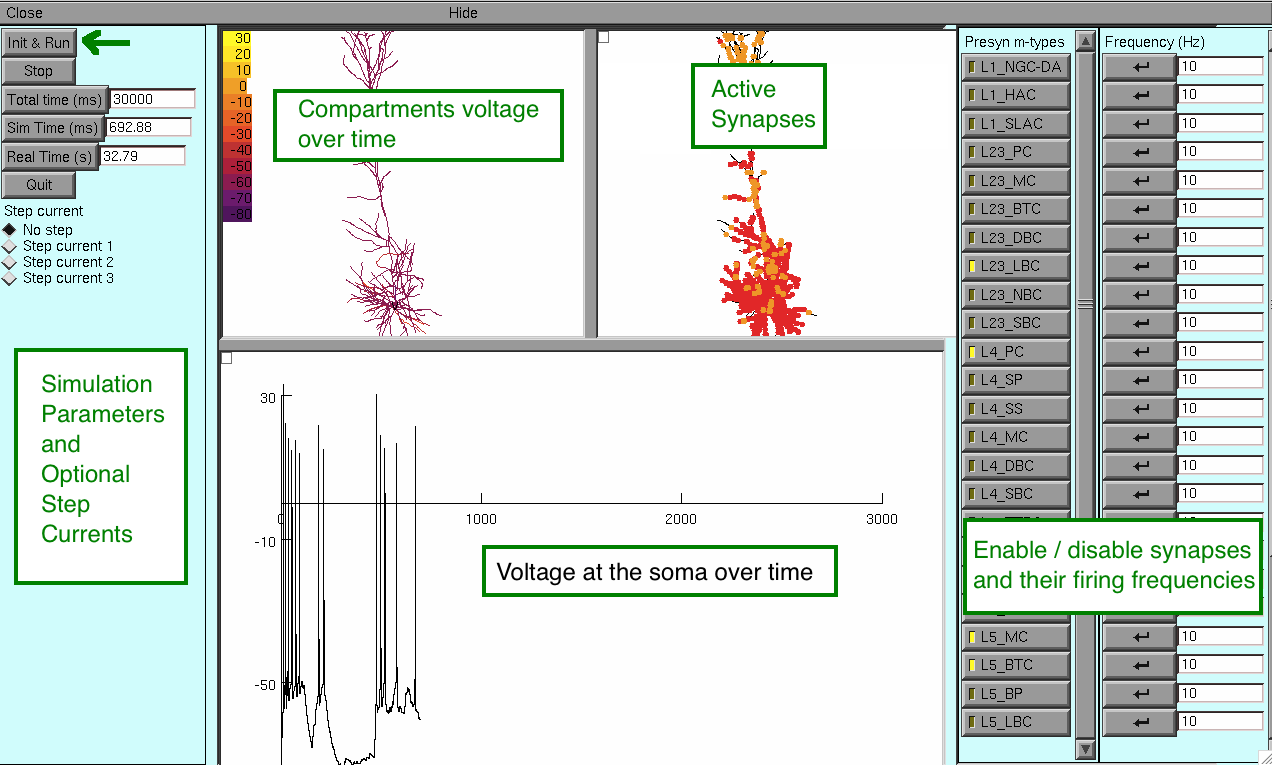

In [2]:
# Display an explanation of NEURON's graphical interface 
from IPython.display import Image
Image("./NEURON_NMC_nrniv.png")

Explore the interface of NEURON and different simulation parameters. Proceed to the next step once you are ready.

# Exercise 2 - Creating NEURON experiments with Python

In NEURON, simulation details are specified in the 'hoc' programming language. The following will load the simulation details:

In [1]:
from neuron import h
# h is an object that allows to call hoc methods from Python
# More info here: http://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/classes/python.html#HocObject

# Now we will call the hoc methods to load all simulation details
import os.path

if os.path.exists('./init.hoc')==False:
    raise Exception("-- hoc FILES NOT FOUND, are you sure you are running this from your NMC_portal folder?.")
else:
    h.load_file("./init.hoc")
    if h.tstop!=30000:
        raise Exception("ERROR: you loaded the files twice. RESTART the notebook kernel and start again.")
    print "-- SIMULATION LOADED SUCCESSFULLY."

h.create_cell(1)        # Argument 1 stands for 'load synapses'
h.create_recording()    # Activate recording of activity 
print "-- CELL AND SYNAPSES LOADED SUCCESSFULLY, proceed to experiment A (current clamp) or B (paired patch-clamp)."


-- SIMULATION LOADED SUCCESSFULLY.
-- CELL AND SYNAPSES LOADED SUCCESSFULLY, proceed to experiment A (current clamp) or B (paired patch-clamp).


# Experiment 2.A - The current pulse

To perform a current injection experiment, we create a stimulus, the execution parameters, and run our simulation:

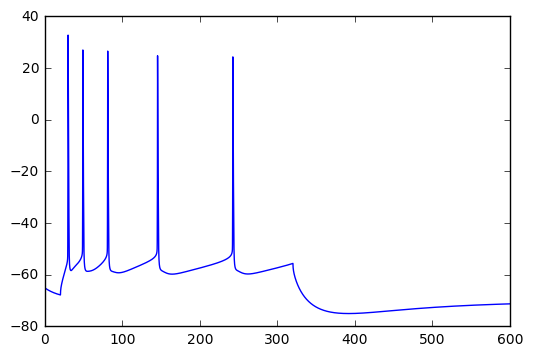

-- SIMULATION COMPLETED.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# We create a stimulation electrode and attach it to the soma
cell = h.cADpyr232_L5_TTPC2_8052133265(1) # Create the cell, 1 stands for "load synapses"

stimulus = h.IClamp(0.5, sec = cell.soma[0])
stimulus.dur = 300        # Duration of stimulus (in ms)
stimulus.delay = 20       # Start time (in ms)
stimulus.amp = 0.69       # Amplitude (nA)

# Define the simulation settings
h.tstop=600                  # Duration (ms)
h.dt=0.5                    # Interpolation step size

# Initialise recordings 
time = h.Vector()
voltage = h.Vector()
time.record(h._ref_t)
voltage.record(cell.soma[0](0.5)._ref_v)
h.run()                     # Run simulation

# Records the simulation results
#h.save_recording()          #save recording

# This will plot the result
#pp.plot(list(h.time), list(h.voltage))
plt.plot(time,voltage)
plt.show()

print "-- SIMULATION COMPLETED."


#### Bonus: 
if you configure the current injection with the following parameters:
- stepcurrent.amp = 0.59, 0.64 or 0.69
- stepcurrent.del = 700
- stepcurrent.dur = 2000

you'll be able to reproduce the current injection plots on the [details page](https://bbp.epfl.ch/nmc-portal/microcircuit#/metype/L5_TTPC2_cADpyr/details) of your morphology on the NMC portal

# Experiment 2.B - The paired patch-clamp

Now that you know how to load a neuron and inject current, we will now use NEURON to run a paired patch-clamp experiment. The setup is the following:
1. Two neurons connected by several synapses; 
2. We inject a train of 9 current pulses on the *pre*-synaptic cell;
3. The voltage at the soma of the *post*-synaptic cell is measured;

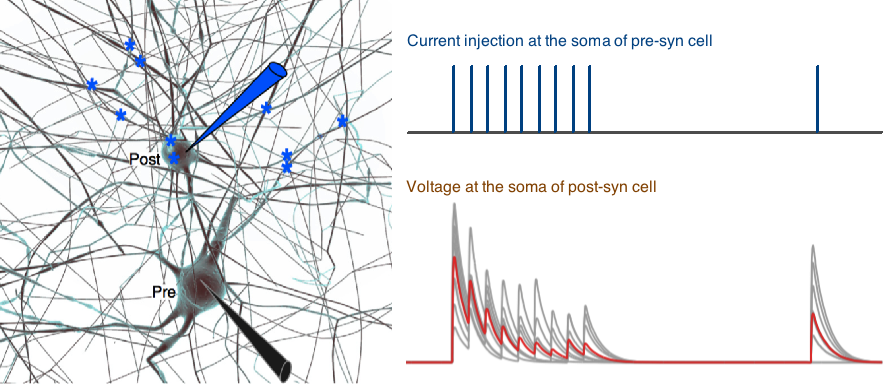

In [3]:
# Visualise the experimental set-up, and the expected output
from IPython.display import Image
Image("./NEURON_NMC_portal.png")

### Changing synapses properties

The file synapses/synapses.tsv contains all information about the afferent synapses on our neuron. It's represented as a matrix in the following format:
- First row: number of rows/synapses, number of columns
- For every row: synapse_id, pre_cell_id, pre_mtype, sectionlist_id, sectionlist_index, seg_x, synapse_type, dep, fac, use, tau_d, delay, weight

The file 'synapses/mtype_map.tsv' provides you the mapping between pre_mtyp field and the representative string (e.g. m-type id 28 relates to the 'L5_TTPC1' morphologycal type).

For the moment, our neuron includes all synapses. We are trying to simulate the activity of a pair of neurons, therefore, for our experiment we will only keep the synapses of a single pre-synaptic neuron. To do this, open your synapses/synapses.tsv and disable all synapses except the ones from a pre-synaptice neuron of your choice (preferebly of m-type 28 / L5_TTPC1).
- NOTE: If you are using the L5_TTPC2_cADpyr provided in the tutorial files, we already disabled the required synapses in the file synapses/synapses.paired-patch-clamp.tsv. You can use it by replacing synapses.tsv by synapses.paired-patch-clamp.tsv. The code below will allow you to do that. Similarly, you can use the file "synapses/synapses.all.tsv" to restore the original file

In [ ]:
import shutil               # Interact with files in Python

# Use the synapses file with only the L5_TTPC1_cADpyr -> L5_TTPC2_cADpyr pathway activated
shutil.copyfile("synapses/synapses.paired-patch-clamp.tsv", "synapses/synapses.tsv")

Once you have completed the changes,  clean all data from the previous experiment: Click menu Kernel > Restart, then re-run "Loading Experimental Data", and continue from here. The next code will set the spiking instants of the synapses:

In [39]:
cell = h.cell               # See template.hoc for the implementation of the cell model
synapses = cell.synapses    # See synapses/synapses.hoc for the implementation of the synapses

# Enable the synapses
for i in range(0, int(synapses.n_of_mtypes)):
    synapses.were_active_pre_mtypes.x[i]=0
    synapses.active_pre_mtypes.x[i] = 1

synapses.update_synapses(h.synapse_plot) 

#add settings for enabled synapses
netstim_list = list(synapses.netstim_list)
for netstim in netstim_list:
    netstim.start = 200          # Delay of 100 ms for the first pre-synaptic spike
    netstim.interval = 1000/30   # ~30 Hz
    netstim.number = 9           # 9 spikes in total
    netstim.noise = 0

print "-- SYNAPSES ACTIVATED SUCCESSFULLY, proceed to the next step."

-- SYNAPSES ACTIVATED SUCCESSFULLY, proceed to the next step.


Now we set the configuration parameters, run the simulation and plot the output:

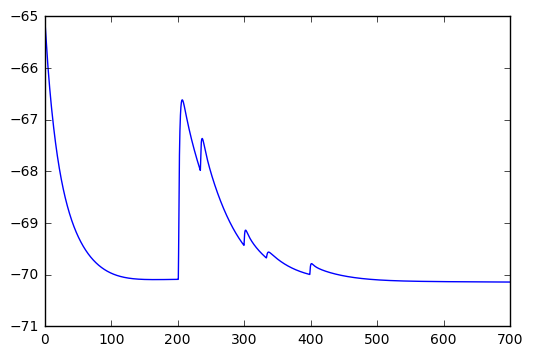

-- SIMULATION COMPLETED.


In [40]:
%matplotlib inline
import matplotlib.pyplot as pp
h.tstop=700                 #length of simulation (ms)
h.dt=0.05                   #interpolation step size

h.run()                     #run simulation
h.save_recording()          #save recording

time = list(h.time)
voltage = list(h.voltage)
pp.plot(time, voltage)
pp.show()
print "-- SIMULATION COMPLETED."

Execute the previous script a few times: you can see that, because we are adding noise to the simulation, every execution is slight different.

#### Exercise

Run 10 simulations and plot the average. (Hint: each execution stores the solution voltage in the *h.voltage* vector)

-- Simulation 0:


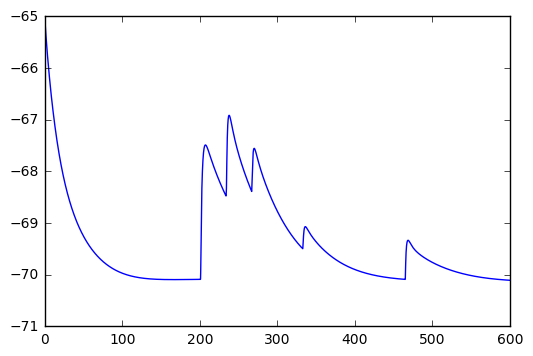

-- Simulation 1:


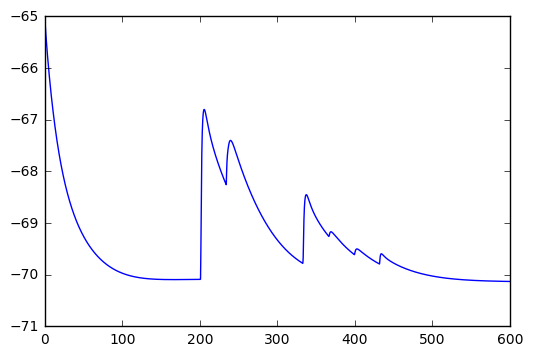

-- Simulation 2:


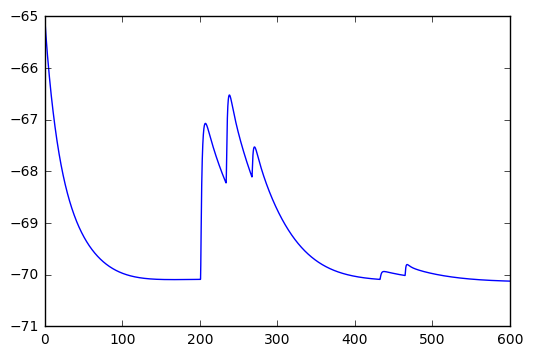

-- Simulation 3:


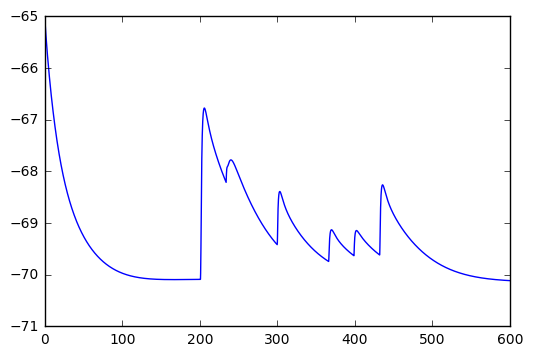

-- Simulation 4:


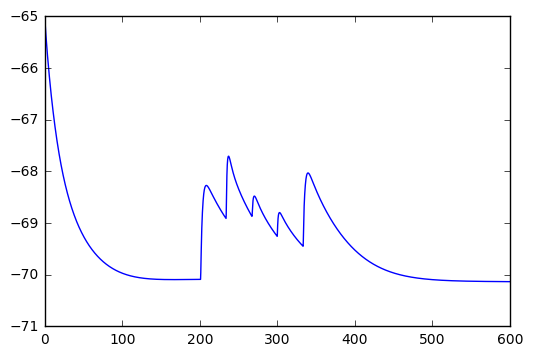

-- Simulation 5:


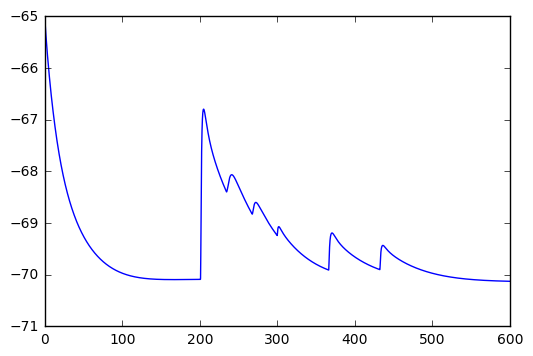

-- Simulation 6:


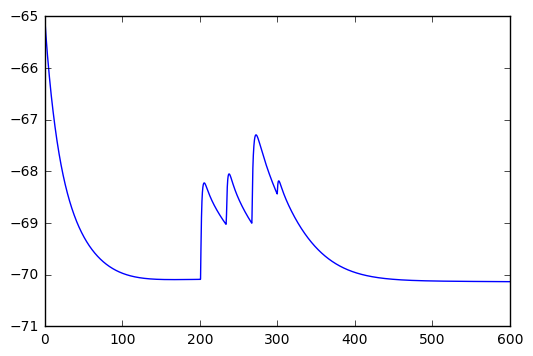

-- Simulation 7:


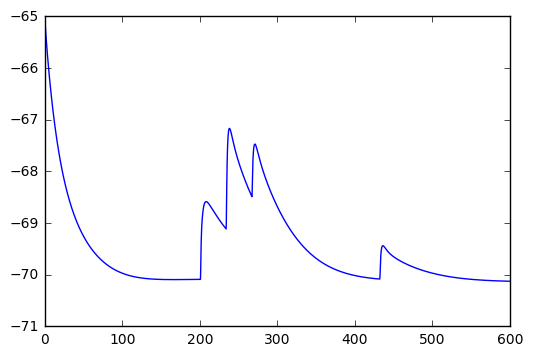

-- Simulation 8:


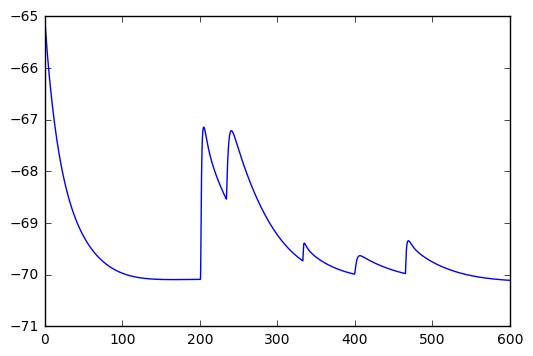

-- Simulation 9:


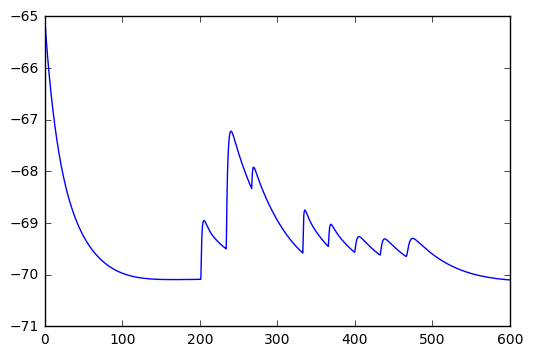

In [41]:
%matplotlib inline
import matplotlib.pyplot as pp

h.tstop=600              #length of simulation (ms)
h.dt=0.05                #interpolation step size
simulations_count = 10   #number of simulations to average from

#run all experiments
voltages = []
for idx in range(simulations_count):
    print "-- Simulation "+ str(idx) + ":"
    h.run()                     
    h.save_recording()
    
    #plot current execution
    pp.plot(list(h.time), list(h.voltage))
    pp.show()
    
    #place a copy of voltage on the final voltages vector
    voltage = list(h.voltage)
    voltages.append(voltage)

-- Average values for 10 simulations:


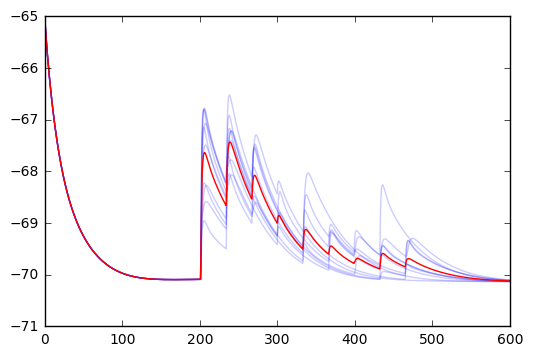

In [52]:
# TODO: calculate averages vector
import numpy
voltages = numpy.array(voltages)
avgs = voltages.mean(axis=0)
    
# Plot original recordings and average
print "-- Average values for " + str(simulations_count) + " simulations:"
[pp.plot(list(h.time), voltages[i], color = 'b', alpha = 0.2) for i in range(len(voltages))]
pp.plot(list(h.time), avgs, 'r-')
pp.xlabel("Time (ms)")
pp.ylabel("Voltage (mV)")
pp.show()

#### Post-synaptic excitatory potential

Now we will run a single stimulus from the pre-synaptic neuron to visualize the response in post-synaptic potential on the post-synaptic neuron:

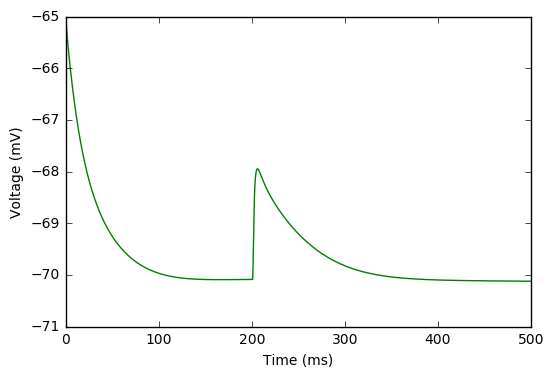

-- SIMULATION COMPLETED


In [60]:
# Add settings for enabled synapses
    
netstim_list_2 = list(synapses.netstim_list)
for netstim2 in netstim_list_2:
    netstim2.start = 200  # delay of 200 ms for the first spike
    netstim2.number = 1   # ONE single spike

h.tstop=500              # Simulation duration (ms)
h.dt=0.05                # Interpolation step size


time = h.Vector()
voltage = h.Vector()
time.record(h._ref_t)
voltage.record(cell.soma[0](0.5)._ref_v)
h.run()                     
h.save_recording()
    
#plot current execution
pp.plot(list(time), list(voltage), 'g-')
pp.xlabel("Time (ms)")
pp.ylabel("Voltage (mV)")
pp.show()

print "-- SIMULATION COMPLETED"